# Evaluate melt rates (circumpolar and Amundsen Sea)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot, finished_plot
from nemo_python_git.constants import rho_ice, sec_per_year, sec_per_day, line_colours
from nemo_python_git.grid import region_mask
from nemo_python_git.projects.eANT025 import plot_annual_melt_overview

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test6/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [3]:
def mask_land(nemo_mesh, file_var):
    mask = (nemo_mesh.tmask.isel(nav_lev=0) != 0) | (nemo_mesh.misf == 0)
    lon_plot = np.ma.masked_where(mask, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(mask, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(mask, file_var.values)
    return lon_plot, lat_plot, plot_var 

def plot_land(nemo_mesh, file_var):
    mask = (nemo_mesh.misf!=0) 
    lon_plot = np.ma.masked_where(mask, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(mask, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(mask, file_var.values)
    return lon_plot, lat_plot, plot_var 

## Ice shelf melt rates

In [4]:
nemo_mesh_ds = xr.open_dataset(nemo_mesh).isel(time_counter=0)
mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350))

#### Amundsen Sea

In [5]:
from calendar import monthrange

# load nemo simulations
gridT_files = glob.glob(f'{run_folder}files/*SBC*')
nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder
# # nemo_ds   = xr.open_dataset(gridT_files[0])
days_per_month = [monthrange(nemo_ds.time_counter.dt.year[i].values, nemo_ds.time_counter.dt.month[i].values)[1] for i in range(0,nemo_ds.time_counter.size)]
nemo_ds   = nemo_ds.assign({'days_per_month':(('time_counter'), days_per_month)})
melt_rate = ((nemo_ds.fwfisf)*nemo_ds['days_per_month']*sec_per_day).sum(dim='time_counter')/(rho_ice*len(np.unique(nemo_ds.time_counter.dt.year)))

In [30]:
melt_rate_sub = melt_rate.isel(x_grid_T=slice(450, 900), y_grid_T=slice(130,350))

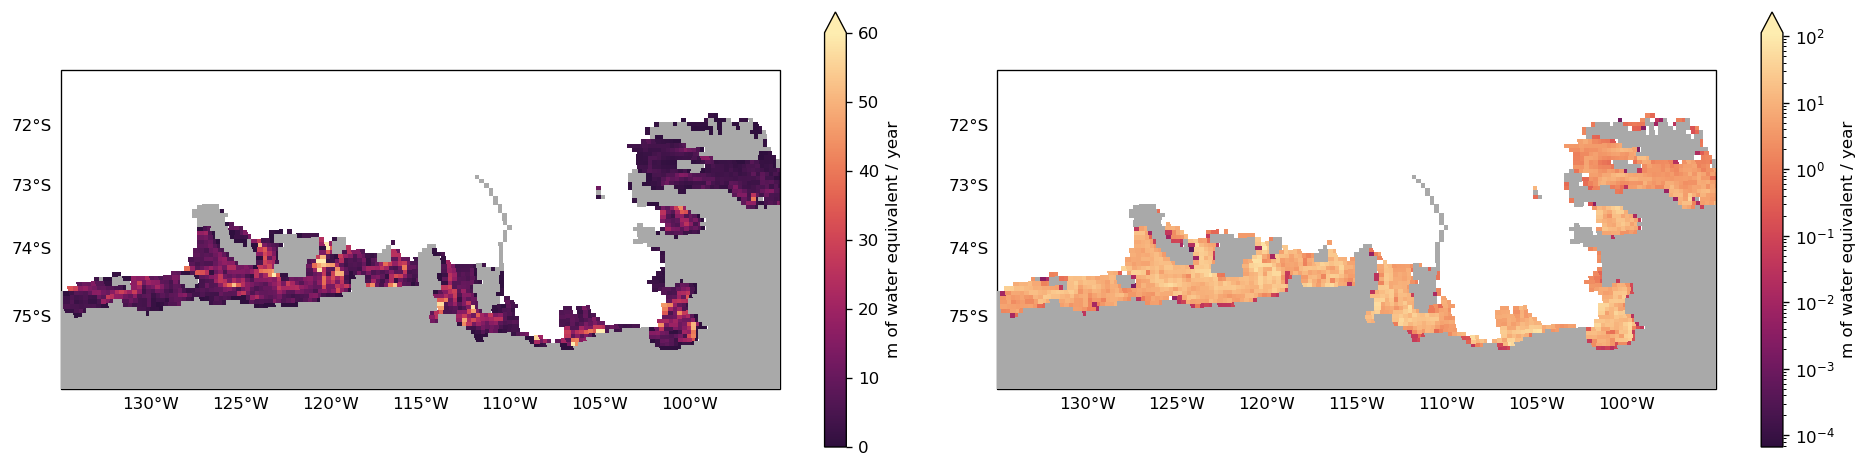

In [9]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average    
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)

#------------- Plot figure -----------------
fig, ax = plt.subplots(1,2, figsize=(16,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=120)

lon_plt, lat_plt, var_plt = mask_land(mesh_sub, melt_rate_sub)
img1 = ax[0].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                     vmin=0, vmax=60, cmap=cmocean.cm.matter_r)

img2 = ax[1].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                    cmap=cmocean.cm.matter_r, norm=cl.LogNorm())
img = [img1, img2]
for n, axis in enumerate(ax.ravel()):
    axis.set_extent([-95, -135, -76, -71], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

    axis.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, 
              cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
    
    plt.colorbar(img[n], ax=axis, extend='max', label='m of water equivalent / year')

plt.tight_layout()

## Circumpolar Antarctic

vmin and vmax must be positive and non-zero when using a logarithmic colormap (lognorm=True), so allowing pcolormesh to choose limits instead


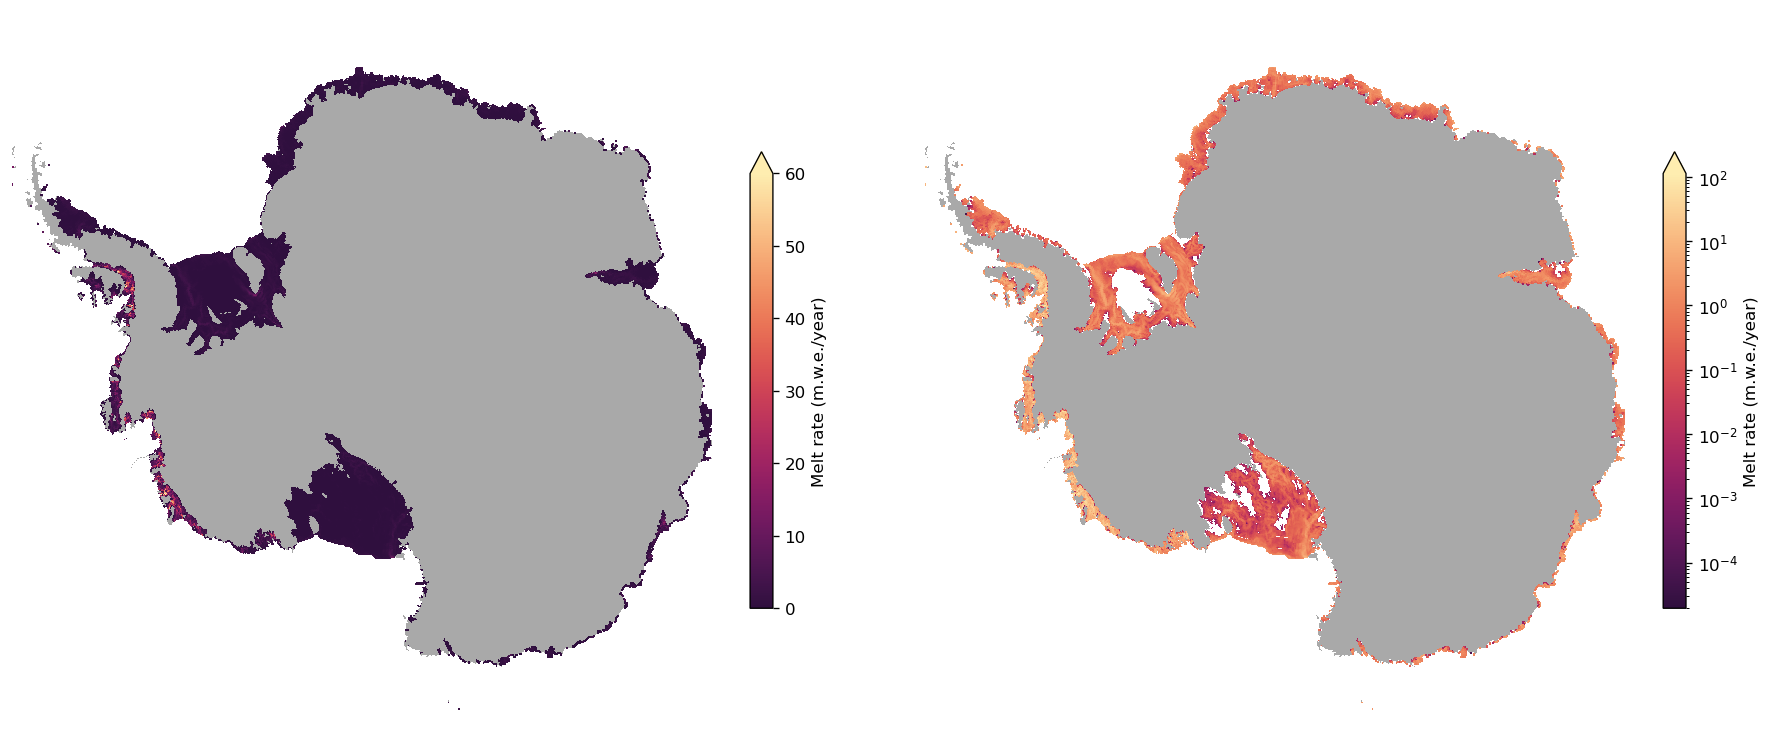

In [8]:
fig, ax = plt.subplots(1,2, figsize=(18,8), dpi=120)

img1 = circumpolar_plot(melt_rate, nemo_mesh_ds, ax=ax[0], masked=False, make_cbar=False, title='',
                        vmin=0, vmax=60, ctype=cmocean.cm.matter_r, shade_land=True, lat_max=-66)

img2 = circumpolar_plot(melt_rate, nemo_mesh_ds, ax=ax[1], masked=False, make_cbar=False, title='',
                        lognorm=True, ctype=cmocean.cm.matter_r, shade_land=True, lat_max=-66)

img = [img1, img2]
for n, axis in enumerate(ax.ravel()):
    plt.colorbar(img[n], ax=axis, extend='max', label='Melt rate (m.w.e./year)', fraction=0.03)

## Calculate total melt over time (gigatonnes)

In [6]:
annual_melt_rate = ((nemo_ds.area_grid_T*nemo_ds.fwfisf)*nemo_ds['days_per_month']*sec_per_day).resample(time_counter='Y').sum()*1e-12 # kg/m2/s --> kg/s

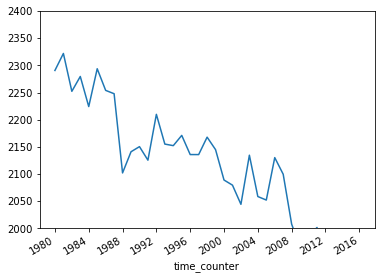

In [7]:
annual_melt_rate.sum(dim=['x_grid_T','y_grid_T']).plot(ylim=(2000,2400))

### Separate melt rate by region

In [74]:
all_melt, annual_all_melt = calculate_regional_melt_rate('all', nemo_ds)
west_melt, annual_west_melt = calculate_regional_melt_rate('west_antarctica', nemo_ds)
east_melt, annual_east_melt = calculate_regional_melt_rate('east_antarctica', nemo_ds)

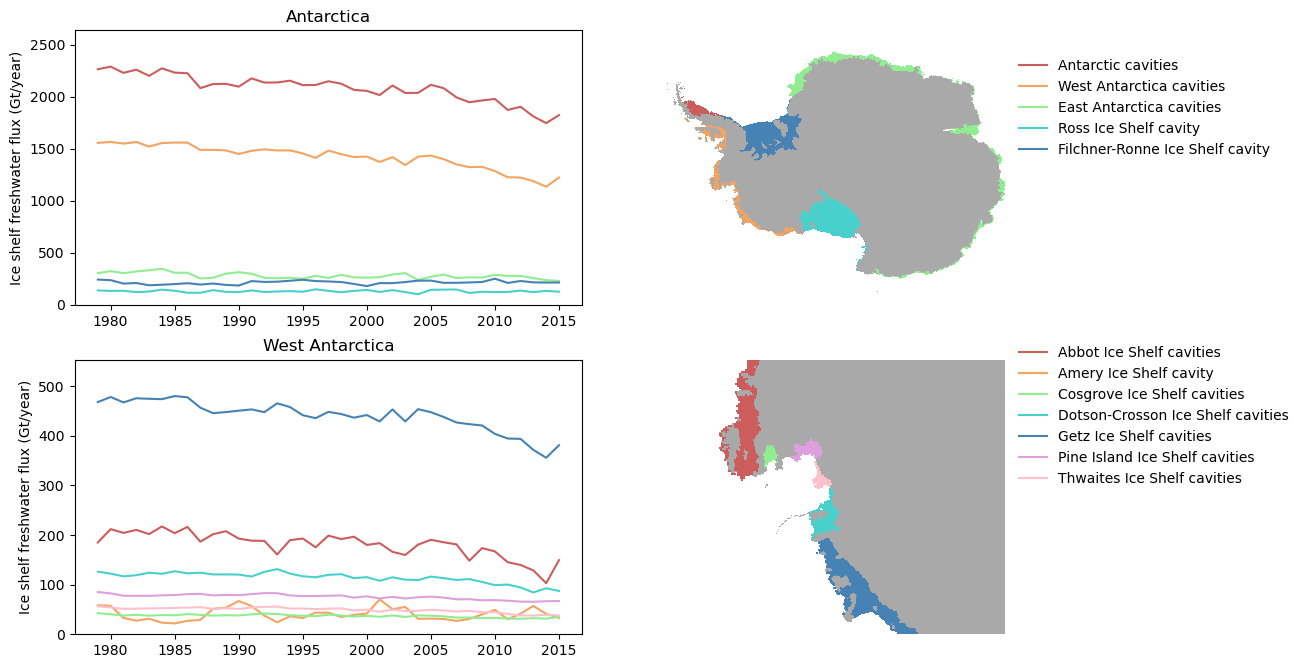

In [6]:
plot_annual_melt_overview(gridT_files)

In [8]:
colors = ['IndianRed', 'SandyBrown', 'LightGreen', 'MediumTurquoise', 'SteelBlue', 'Plum', 'Pink']
mesh_mask ='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'
nemo_meshmask = xr.open_dataset(mesh_mask).squeeze()

##### Double check masking

In [9]:
nemo_domcfg = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc').squeeze()
mask0, _, region_name = region_mask('all', nemo_domcfg, option='cavity', return_name=True)
mask1, _, region_name = region_mask('west_antarctica', nemo_domcfg, option='cavity', return_name=True)
mask2, _, region_name = region_mask('east_antarctica', nemo_domcfg, option='cavity', return_name=True)
not_in_mask = xr.where((mask0.rename({'x':'x_grid_T', 'y':'y_grid_T'})==0)*(nemo_ds.fwfisf.isel(time_counter=0) != 0)*(~np.isnan(nemo_ds.fwfisf.isel(time_counter=0))),
                       1, 0)

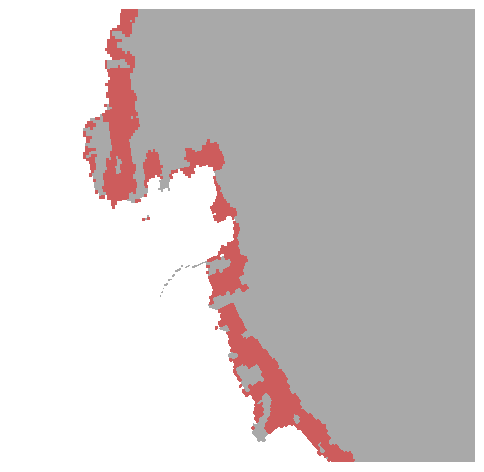

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=100)

kwags = {'masked':False, 'make_cbar':False, 'title':''}

img1 = circumpolar_plot(mask0, nemo_meshmask, ax=ax, ctype=colors[0], shade_land=True, zoom_amundsen=True, **kwags)

In [6]:
# from nemo_python_git.constants import region_edges, region_edges_flag, region_names, region_points
# from nemo_python_git.utils import remove_disconnected, closest_point
from nemo_python_git.grid import build_shelf_mask, build_ice_mask

In [37]:
ds = nemo_domcfg.copy()
mask, ds     = build_shelf_mask(ds)
shelf_lat=-58 # from NEMO constants
shelf_depth=3000

bathy = ds['bathy_metry'].squeeze()
ocean_mask = xr.where(ds['bottom_level']>0, 1, 0).squeeze()
# # Apply lat-lon bounds and bathymetry bound to ocean mask
mask = ocean_mask*(ds['nav_lat'] <= shelf_lat)*(bathy <= shelf_depth)
# Remove disconnected seamounts
# point0 = closest_point(ds, shelf_point0)
# mask.data = remove_disconnected(mask, point0)

ice_mask, ds = build_ice_mask(ds)
mask *= ice_mask

the mask misses cells because of the cutoff depth in constants.py --- I guess my larger domain contains a few ice shelf cavities that are very deep relative to the regional configuration. Need to figure out a way to generalize this in the code so that the system still works for Kaitlin. Also don't want to deepen what is defined as shelf for everything else.

In [38]:
not_in_mask2 = xr.where((mask==0)*(nemo_ds.fwfisf.isel(time_counter=0).values != 0)*(~np.isnan(nemo_ds.fwfisf.isel(time_counter=0).values)),\
                        1, 0)

In [39]:
sum(sum(not_in_mask2)) 

<xarray.DataArray ()>
array(0)
Coordinates:
    time_counter  float32 0.0

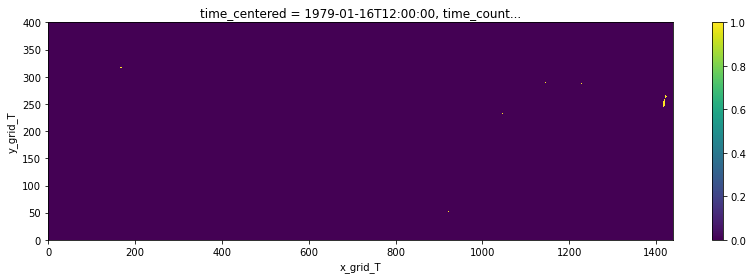

In [66]:
not_in_mask.plot(figsize=(14,4), ylim=(0,400))

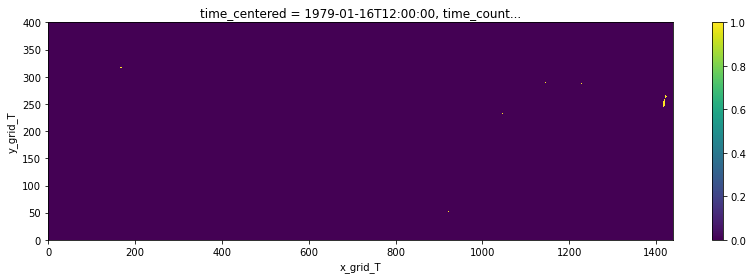

In [41]:
not_in_mask.plot(figsize=(14,4), ylim=(0,400))

Mask doesn't quite seem to include all points that are ice shelf! Need to fix

# Combine into a generalized plot that does everything

In [ ]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average    
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)

#------------- Plot figure -----------------
fig, ax = plt.subplots(1,2, figsize=(10,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=120)

ax.set_extent([-95, -135, -76, -71], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

# kg/m2/s / kg/m3 --> m/s *sec_per_year --> m / year
lon_plt, lat_plt, var_plt = mask_land(mesh_sub, melt_rate_sub)
img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=60, cmap=cmocean.cm.matter_r)
ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
plt.colorbar(img, ax=ax, extend='max', label='m of water equivalent / year')